In [1]:
%matplotlib inline
import requests
import json
import pandas as pd
from vega import Vega
import ipywidgets as widgets
carto_url ="https://wri-rw.carto.com/api/v2/sql"
api_url = "https://api.resourcewatch.com/v1/"

# Water dashboard widgets definition

Widgets for a proof-of-concept water dashboard.

## Water + Cities

| Statement    | 190 or 40% (190/417) of cities with > 1,000,000 people are in high water risk areas |  
|--------------|:--------------|  
| Visual       | Text         |  
| Data         | - https://nordpil.com/resources/world-database-of-large-cities/     - Aqueduct water risk|  
| Methodology  | (In QGIS) - urbanareas1_1 → filter “pop2015” >= 1000 (in thousand inhabitants) aqueduct_global_maps_21_shp → filter “_default” >= 3 (3-4 is high risk, 4-5 is extremely high risk) “Count points in Polygon” QGIS analysis → created NUMPOINTS attribute, basic summary stat = 190 cities with >1 mill people in high water risk areas Can clip by country? - Could, but would likely become 1-5 data points in a widget |   

The data is stored in cartodb.
The data came from the join of this 2 datasets:  
* 5e156d22-7f84-4cd2-9724-c1a519a83e0a
* 5903f1d7-2240-4591-b970-33b32fe3be54   



* **Dataset_id:**  6d99441e-5faa-4c61-967f-01c9fe60624b
* **widget_id:**

### Widget definition

```json
"widgetConfig":{
    "type":"text",
    "data":{
        "url":"SELECT count(*) over () total, (count(*) Filter (where _default>=4) over ()) as n_cities,  (100*(count(*) Filter (where _default>=4) over ())/(count(*) over ()))::numeric perc  FROM water_plus_cities limit 1"
        }
    "template": "{{n_cities}} or {{perc}} ({{n_cities}}/{{total}}) of cities with 1,000,000 people or more are in high water risk areas",
    "params_config": [],
    "template_config": [{
        "key": "n_cities"
        },
        {
        "key": "perc_cities",
        "suffix": "%"
        }]
}
```


In [2]:
cartoQuery = "with r as (SELECT * FROM ne_10m_populated_places_simple where pop_max>1000000) SELECT s._default, r.name, r.pop_max FROM aqueduct_global_dl_20150409 s inner join r on st_intersects(r.the_geom, s.the_geom) order by _default desc"
payload={'q': cartoQuery}
r = json.dumps(requests.get(carto_url,params=payload).json()['rows'])
water_city = pd.read_json(r, orient='records')
water_city.head(3)

,_default,name,pop_max
0,4.639710,Sanaa,2008000
1,4.618374,Casablanca,3181000
2,4.563580,Agra,1592000


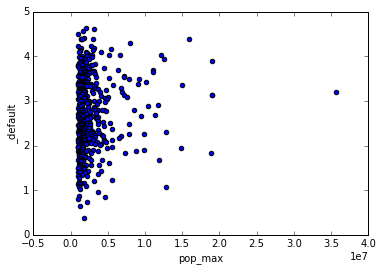

In [3]:
water_city.plot(y='_default', x='pop_max', kind='scatter')

## Water + Society

| Statement    | Countries that will experience the greatest increase in projected water stress in the year 2040 if we continue business as usual |  
|--------------|:---|  
| Visual       | Country ranking  |  
| Data         | Aqueduct Water Risk Atlas - water stress country rankings |  
| Methodology  | http://www.wri.org/sites/default/files/aqueduct-water-stress-country-rankings-technical-note.pdf |  

* **Dataset_id:**  eb33d4b8-26e2-48de-a153-82c9f86263b5
* **widget_id:** 

### Widget definition

In [4]:
vega_spec={"height":300,
  "padding": {"top": 25,"left": 0,"bottom": 30,"right": 0},
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT country, values, iso, row_number() over (order by values desc) as rank FROM aqueduct_water_stress_country_ranking_bau where type = 'all' and year = '2040' and values!=0 order by values desc",
      "format": {"type": "json","property": "rows"},
      "transform": [{"type": "sort","by": "rank"}]
    },
    {
      "name": "max",
      "source": "table",
      "transform": [{"type": "aggregate","summarize": {"rank": ["max"]}}]
    },
    {
      "name": "head",
      "source": "table",
      "transform": [
        {
          "type": "cross",
          "with": "max",
          "filter": "datum.a.rank===datum.b.max_rank || datum.a.rank<=10"
        },
        {"type": "sort","by": "a.rank"} 
      ]
    }
  ],
  "scales": [
    {
      "name": "bar",
      "type": "linear",
      "range": "width",
      "domain": {"data": "table","field": "values"}
    },
    {
      "name": "vertical_head",
      "type": "ordinal",
      "range": "height",
      "domain": {
        "data": "head",
        "field": "a.rank"
      }
    }
  ],
  "marks": [
        {
          "type": "text",
          "from": {"data": "head"},
          "properties": {
            "enter": {
              "x": {"value": 20},
              "y": {"field": "a.rank","scale": "vertical_head"},
              "text": {
                "template": "{{datum.a.rank}}.- {{datum.a.country}}"
              },
              "baseline": {"value": "middle"},
              "fontSize": {"value": 13},
              "fill": {"value": "#555555"},
              "align": {"value": "left"}
            }
          }
        },
        {
          "name": "head",
          "type": "rect",
          "from": {"data": "head"},
          "properties": {
            "enter": {
              "x":{"field": {"group": "width"},"mult": 0.35},
              "width":{"scale": "bar", "field": "a.values","mult": 0.5},
              "y": {
                "field": "a.rank",
                "scale": "vertical_head",
                "offset": -6
              },
              "height": {"value": 10},
              "fill": {"value": "#0055ff"},
              "fillOpacity": {"value": 1}
     }
     }
     }   
  ]
}

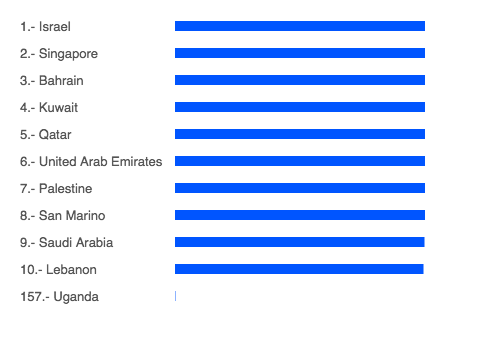

In [5]:
Vega(vega_spec)

## Water + Food 

| Statement    | % (or total area?) crop growing in high water risk areas by 2040 (Q for Vizzuality - can a widget be made on aqueduct food data that could be easily updated when they produce the new water indicators? Is it better to hold off on this?)|    
|--------------|:---|  
| Visual       | Bar Graph by crop type |  
| Data         | Aqueduct Food |  
| Methodology  | http://www.wri.org/sites/default/files/aqueduct-water-stress-country-rankings-technical-note.pdf |  

* **Dataset_id:**  
* **widget_id:** 

### Widget definition

In [6]:
widgets.HTML(
    value='<iframe src="http://aqueduct-water-food-security.herokuapp.com/embed?state=eyJmaWx0ZXJzIjp7ImNyb3AiOiJhbGwiLCJzY29wZSI6Imdsb2JhbCIsImNvdW50cnkiOiJJTkQiLCJwZXJpb2QiOiJ5ZWFyIiwicGVyaW9kX3ZhbHVlIjoiYmFzZWxpbmUiLCJ5ZWFyIjoiYmFzZWxpbmUiLCJmb29kIjoibm9uZSIsImluZGljYXRvciI6IjRiMDAwZGVkLTVmNGQtNGRiZC04M2M5LTAzZjJkZmNkMzZkYiIsImlycmlnYXRpb24iOlsiaXJyaWdhdGVkIiwicmFpbmZlZCJdLCJ0eXBlIjoiYWJzb2x1dGUifSwiZW1iZWQiOnsiaWQiOiI1YmUxNmZlYS01YjFhLTRkYWYtYTllOS05ZGMxZjZlYTZkNGUifX0=" width="600" height="420" frameborder="0" style="border:0" allowfullscreen></iframe>',
    disabled=False
)

## Water + Energy

Pending a better data source  

| Statement    | % (or number) of power plants exposed to water risk (much more interesting to do generation capacity at risk, but database not ready for that yet)|    
|--------------|:---|  
| Visual       | map |  
| Data         | Aqueduct water risk, Power watch data|  
| Methodology  | In power watch data - fuel1, fuel2, fuel3, or fuel4 attribute fields = thermal source (gas, oil, coal, geothermal, or nuclear)  Overlay thermal power plant locations with water risk data, count the number that are within high (>=3) water risk |  

* **Dataset_id:**  
* **widget_id:** 


### Widget definition

## Water + Forests

| Statement    |Watersheds are at risk due to deforestation|    
|--------------|:---|  
| Visual       | Pie chart of % watersheds with each risk category (1-5) due to recent forest loss Data |  
| Data         | GFW Water |  
| Methodology  | # of watersheds in each risk category ÷ total # watersheds - http://www.wri.org/sites/default/files/wri16_TECH_GFW-Water_draft7.pdf |  

* **Dataset_id:**  
* **widget_id:** 

### Widget definition

In [7]:
query = 'SELECT count(rs_tl_c), rs_tl_c FROM river_basins group by rs_tl_c'

In [8]:
vegaSpec={
  "data": [
    {
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT count(rs_tl_c) x, rs_tl_c as y FROM river_basins where rs_tl_c != 10  group by rs_tl_c",
      "name": "table",
      "format": {"type": "json","property": "rows"}
    },
    {
      "from":"table",
      "name": "pie",
      "transform": [{"type": "pie","field": "x"}]
    }
  ],
  "marks": [
    {
      "from": {
        "data": "table",
        "transform": [{"type": "pie","field": "x"}]
      },
      "type": "arc",
      "properties": {
        "enter": {
          "x": {"mult": 0.5,"field": {"group": "width"}},
          "y": {"mult": 0.5,"field": {"group": "height"}},
          "fill": {"field": "x","scale": "color"},
          "stroke": {"value": "white"},
          "endAngle": {"field": "layout_end"},
          "startAngle": {"field": "layout_start"},
          "innerRadius": {"value": 45},
          "outerRadius": {"value": 65}
        }
      }
    }
  ],
  "width": 300,
  "height": 300,
  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "range": "category20c",
      "domain": {"data": "table","field": "x_percent"}
    }
  ],
  "padding": {"top": 0,"left": 0,"right": 0,"bottom": 0}
}

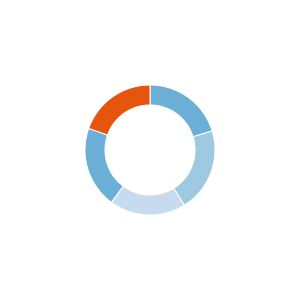

In [9]:
Vega(vegaSpec)

## Water + Forests

| Statement    |Watersheds are at risk due to erosion|    
|--------------|:---|  
| Visual       | Map of top 10 watersheds facing highest risk of erosion (top 10 are all concentrated in SE asia + NZ, should be showable on a widget map) |  
| Data         | GFW Water |  
| Methodology  | http://www.wri.org/sites/default/files/wri16_TECH_GFW-Water_draft7.pdf - page 28 shows a map |  

* **Dataset_id:**  
* **widget_id:** 

### Widget definition

In [10]:
widgets.HTML(
    value='<iframe src="https://resourcewatch.carto.com/u/wri-rw/builder/27c585d4-da6e-42ea-9dee-49c554cdf3cd/embed" width="800" height="600" frameborder="0" style="border:0" allowfullscreen></iframe>',
    disabled=False
)

## Water + Biodiversity (and/or Climate)

| Statement    |Bleaching events are bad and are increasingly likely to happen|    
|--------------|:---|  
| Visual       | # of bleaching events in the last 30 days within reef boundaries Data |  
| Data         | GFW Water |  
| Methodology  | http://www.wri.org/sites/default/files/wri16_TECH_GFW-Water_draft7.pdf - page 28 shows a map |  

* **Dataset_id:**  
* **widget_id:** 

Data management ---> nrt scrip that updates it

https://resourcewatch.carto.com/u/wri-rw/dataset/reefs_alerts

### Widget definition

```json
"widgetConfig":{
    "type":"text",
    "data":{
        "url":"SELECT alert_1 as alerts FROM reefs_alerts"
        }
    "template": "{{alerts}} of bleaching events in the last 30 days within reef boundaries Data",
    "params_config": [],
    "template_config": [{
        "key": "alerts"
        }]
}
``` 

In [15]:
cartoQuery = "SELECT alert_1 as alerts FROM reefs_alerts"
payload={'q': cartoQuery}
r = json.dumps(requests.get(carto_url,params=payload).json()['rows'])
water_city = pd.read_json(r, orient='records')
water_city.head(3)

,alert_1
0,11


## Water + Disasters + Society

| Statement    |Population at risk of flooding in 1/50 year events in 2030|    
|--------------|:---|  
| Visual       | Statement |  
| Data         | Population affected by flood data for 1/50 year storm events - http://www.wri.org/resources/data-sets/aqueduct-global-flood-risk-maps |  
| Methodology  | Total pop Column title: P30_24_50 (affected population, projected risks in 2030, SSP2, RCP4.5, 50 years), P30_28_50 (affected population, projected risks in 2030, SSP2, RCP8.5, 50 years), or P30_38_50 (affected population, projected risks in 2030, SSP3, RCP8.5, 50 years)? Ask Tianyi |  
https://resourcewatch.carto.com/u/wri-rw/dataset/aqueduct_global_flood_risk_data_by_country_20150304
* **Dataset_id:** 01ddff59-8cbc-4420-8c0d-9d8317a63292
* **widget_id:** 

### Widget definition

```json
"widgetConfig":{
    "type":"text",
    "data":{
        "url":"SELECT round(sum(p30_24_50)/1000000) people FROM aqueduct_global_flood_risk_data_by_country_20150304"
        }
    "template": "{{people}} of people affected by floods for 1/50 year storm events in 2030",
    "params_config": [],
    "template_config": [{
        "key": "people",
        "suffix": "Millions"
        }]
}
``` 

In [4]:
cartoQuery = "SELECT round(sum(p30_24_50)/1000000) as people FROM aqueduct_global_flood_risk_data_by_country_20150304"
payload={'q': cartoQuery}
r = json.dumps(requests.get(carto_url,params=payload).json()['rows'])
water_city = pd.read_json(r, orient='records')
water_city.head(3)

,people
0,743


## Water

I will review the visual of this

| Statement    |Surface water is changing over time|    
|--------------|:---|  
| Visual       | Statement |  
| Data         | JRC Occurrence Change Intensity https://global-surface-water.appspot.com/download Absolute change in occurrence between 1984-1999 vs 2000-2015 |  
| Methodology  | Count cells with positive and negative absolute change (above 50%?) |  

* **Dataset_id:** c150c9d6-743f-4bb5-b74a-caabf32da0aa  
* **widget_id:** 

### Widget definition

In [17]:
cartoQuery = 'SELECT%20ST_HISTOGRAM(raster,%20change_abs,%2010,%20true)%20FROM%20"JRC/GSW1_0/GlobalSurfaceWater"'
payload={'sql': cartoQuery}
r = json.dumps(requests.get('https://api.resourcewatch.org/query/c150c9d6-743f-4bb5-b74a-caabf32da0aa',params=payload).json()['data'][0]['change_abs'])
water_city = pd.read_json(r, orient='records')
water_city.head()

,0,1
0,-128.0,263564
1,-105.1,24282
2,-82.2,41095
3,-59.3,110301
4,-36.4,255956


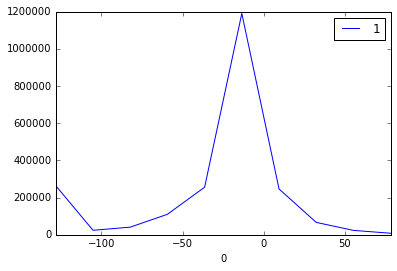

In [19]:
water_city.plot(x=0, y =1);